Group A: Camila Barbagallo, Ryan Daher, Paula Garcia and Rocio Gonzalez

LINK TO VIDEO: https://www.dropbox.com/s/6leboj7cltfbdo8/PSICHI.mp4?dl=0

## 1. Import all Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 2. Sub-functions (step by step)

### 2.1 Function to read the tasklist csvs
This function transforms the tasklist txt files to csv and determines its corresponding column names.

In [2]:
def tasklist_csv(path):
  csvconv = pd.read_fwf(path,encoding='UTF-16')
  csvconv = csvconv.drop([0,1],axis=0)
  csvconv.columns = ['Image Name','PID','Session Name','Session Number','Memory Usage']
  return(csvconv)
  

### 2.2 Function to read the netstat csvs
This function transforms the netstat txt files to csv and determines its corresponding column names.

In [3]:
def netstat_csv(path):
  netstatcsv = pd.read_csv(path,header=None,skiprows=4,encoding='UTF-16',delim_whitespace=True)
  netstatcsv[4][netstatcsv[0]=='UDP'] = netstatcsv[3]
  netstatcsv[3][netstatcsv[0]=='UDP'] = 'NA'
  netstatcsv.columns = ['Protocol','Local Direction','Remote Direction','State','PID']
  netstatcsv = netstatcsv.drop(['State','Protocol'],axis=1)
  return(netstatcsv)

### 2.3 PSI Function


In [4]:
def calc_psi(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN,fulldata):
  #standardizer makes both columns have the same number of rows by filling out spaces with 0.
  def standardizer(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN):
    nocheat_netdf = pd.DataFrame(nocheat_netIN['Remote Direction'].value_counts())
    new_netdf = pd.DataFrame(new_netIN['Remote Direction'].value_counts())
    nocheat_imagedf = pd.DataFrame(nocheat_taskIN['Image Name'].value_counts())
    new_imagedf = pd.DataFrame(new_taskIN['Image Name'].value_counts())
    nocheat_memdf = pd.DataFrame(nocheat_taskIN['Memory Usage'].value_counts())
    new_memdf = pd.DataFrame(new_taskIN['Memory Usage'].value_counts())
    nocheatlist = [nocheat_netdf,nocheat_imagedf,nocheat_memdf]
    newlist = [new_netdf,new_imagedf,new_memdf]

    for i in range(0,len(nocheatlist)):
      nocheataddon = newlist[i].index.difference(nocheatlist[i].index)
      newaddon = nocheatlist[i].index.difference(newlist[i].index)
      for j in newaddon:
        newlist[i].loc[j] = [0]
      for j in nocheataddon:
        nocheatlist[i].loc[j] = [0]
      newlist[i] = newlist[i].reindex(nocheatlist[i].index)

    return [nocheatlist,newlist]
#subpsi calculates the psi for each individual pair 
#to get no Inf, if a value is equal to 0 we change it to 0.001
  def sub_psi(og_perc, new_perc):
      if new_perc == 0:
        new_perc = 0.0001
      if og_perc == 0:
        og_perc = 0.0001
      subpsi = (og_perc - new_perc) * np.log(og_perc / new_perc)
      return (subpsi)
#psi finder calculates the final psi by adding all psis and creating the expexted and observed %
# all of this information is appended to the fulldata, our final dataframe
  def psi_finder(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN):
    nolist, newlist = standardizer(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN)
    psilist =[]
    for i in range(0,len(nolist)):
      nocheat_c = nolist[i]
      new_c = newlist[i]
      og_perc = list(nocheat_c.iloc[:,0]/sum(nocheat_c.iloc[:,0]))
      new_perc = list(new_c.iloc[:,0]/sum(new_c.iloc[:,0]))

      psi_value = 0
      for i in range(0, len(og_perc)):
        psi_value += sub_psi(og_perc[i], new_perc[i])
      psilist.append(psi_value)
    return(psilist)

  fulldata = fulldata.append(pd.Series(psi_finder(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN),index=fulldata.columns),ignore_index=True)
  return(fulldata)

### 2.4. Chi-Square Function

In [5]:
def calc_chi(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN,fulldata):
  #standardizer makes both columns have the same number of rows by filling out spaces with 0.
  def standardizer(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN):
    nocheat_netdf = pd.DataFrame(nocheat_netIN['Remote Direction'].value_counts())
    new_netdf = pd.DataFrame(new_netIN['Remote Direction'].value_counts())
    nocheat_imagedf = pd.DataFrame(nocheat_taskIN['Image Name'].value_counts())
    new_imagedf = pd.DataFrame(new_taskIN['Image Name'].value_counts())
    nocheat_memdf = pd.DataFrame(nocheat_taskIN['Memory Usage'].value_counts())
    new_memdf = pd.DataFrame(new_taskIN['Memory Usage'].value_counts())
    nocheatlist = [nocheat_netdf,nocheat_imagedf,nocheat_memdf]
    newlist = [new_netdf,new_imagedf,new_memdf]

    for i in range(0,3):
      nocheataddon = newlist[i].index.difference(nocheatlist[i].index)
      newaddon = nocheatlist[i].index.difference(newlist[i].index)
      for j in newaddon:
        newlist[i].loc[j] = [0]
      for j in nocheataddon:
        nocheatlist[i].loc[j] = [0]
      newlist[i] = newlist[i].reindex(nocheatlist[i].index)

    return [nocheatlist,newlist]
#subshi calculates the psi for each individual pair 
#to get no Inf, if a value is equal to 0 we change it to 0.001
  def sub_chi(og_perc, new_perc):
      if new_perc == 0:
        new_perc = 0.0001
      if og_perc == 0:
        og_perc = 0.0001
      subchi = ((og_perc - new_perc)**2)/og_perc
      return (subchi)
#chi finder calculates the final chi by adding all chis and creating the expexted and observed %
# all of this information is appended to the fulldata, our final dataframe
  def chi_finder(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN):
    nolist, newlist = standardizer(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN)
    chilist =[]
    for i in range(0,len(nolist)):
      nocheat_c = nolist[i]
      new_c = newlist[i]
      og_perc = list(nocheat_c.iloc[:,0]/sum(nocheat_c.iloc[:,0]))
      new_perc = list(new_c.iloc[:,0]/sum(new_c.iloc[:,0]))

      chi_value = 0
      for i in range(0, len(og_perc)):
        chi_value += sub_chi(og_perc[i], new_perc[i])
      chilist.append(chi_value)
    return(chilist)

  fulldata = fulldata.append(pd.Series(chi_finder(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN),index=fulldata.columns),ignore_index=True)
  return(fulldata)

## 3. Final Chi-Psi Function
This function contains all functions described above.

With one run we compare one file to our 2 no-cheating benchmarks.

Inputs:
- netstat and tasklist txt of both our benchmarks
- netstat and tasklist of 'new' txt file (the one from which we want to know if it's cheating or not)
- dataframe to which you want to append the new observation/row

Outputs:
- Remote Direction_PSI_1 and PSI_2
- Image Name_PSI_1 and PSI_2
- Memory Usage_PSI_1 and PSI_2
- Remote Direction_CHI_1 and CHI_2
- Image Name_CHI_1 and CHI_2
- Memory Usage_CHI_1 and CHI_2


In [6]:
def calc_ob(nocheat_netIN_1,nocheat_netIN_2,new_netIN,nocheat_taskIN_1,nocheat_taskIN_2,new_taskIN,appendata):
  def tasklist_csv(path):
    csvconv = pd.read_fwf(path,encoding='UTF-16')
    csvconv = csvconv.drop([0,1],axis=0)
    csvconv.columns = ['Image Name','PID','Session Name','Session Number','Memory Usage']
    return(csvconv)
  def netstat_csv(path):
    netstatcsv = pd.read_csv(path,header=None,skiprows=4,encoding='UTF-16',delim_whitespace=True)
    netstatcsv[4][netstatcsv[0]=='UDP'] = netstatcsv[3]
    netstatcsv[3][netstatcsv[0]=='UDP'] = 'NA'
    netstatcsv.columns = ['Protocol','Local Direction','Remote Direction','State','PID']
    netstatcsv = netstatcsv.drop(['State','Protocol'],axis=1)
    return(netstatcsv)
  def standardizer(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN):
    nocheat_netdf = pd.DataFrame(nocheat_netIN['Remote Direction'].value_counts())
    new_netdf = pd.DataFrame(new_netIN['Remote Direction'].value_counts())
    nocheat_imagedf = pd.DataFrame(nocheat_taskIN['Image Name'].value_counts())
    new_imagedf = pd.DataFrame(new_taskIN['Image Name'].value_counts())
    nocheat_memdf = pd.DataFrame(nocheat_taskIN['Memory Usage'].value_counts())
    new_memdf = pd.DataFrame(new_taskIN['Memory Usage'].value_counts())
    nocheatlist = [nocheat_netdf,nocheat_imagedf,nocheat_memdf]
    newlist = [new_netdf,new_imagedf,new_memdf]
    for i in range(0,3):
      nocheataddon = newlist[i].index.difference(nocheatlist[i].index)
      newaddon = nocheatlist[i].index.difference(newlist[i].index)
      for j in newaddon:
        newlist[i].loc[j] = [0]
      for j in nocheataddon:
        nocheatlist[i].loc[j] = [0]
      newlist[i] = newlist[i].reindex(nocheatlist[i].index)
    return [nocheatlist,newlist]
  def sub_chi(og_perc, new_perc):
    if new_perc == 0:
      new_perc = 0.0001
    if og_perc == 0:
      og_perc = 0.0001
    subchi = ((og_perc - new_perc)**2)/og_perc
    return (subchi)
  def sub_psi(og_perc, new_perc):
    if new_perc == 0:
      new_perc = 0.0001
    if og_perc == 0:
      og_perc = 0.0001
    subpsi = (og_perc - new_perc) * np.log(og_perc / new_perc)
    return (subpsi)
  def calc_chi_psi(nocheat_netIN_1,nocheat_netIN_2,new_netIN,nocheat_taskIN_1,nocheat_taskIN_2,new_taskIN):
    nocheatNet= [nocheat_netIN_1,nocheat_netIN_2]
    nocheatTask = [nocheat_taskIN_1,nocheat_taskIN_2]
    psilist =[]
    chilist = []
    fulllist = []
    for nc in range(len(nocheatNet)):
      nocheat_netIN = nocheatNet[nc]
      nocheat_taskIN = nocheatTask[nc]

      nocheat_net = netstat_csv(nocheat_netIN)
      new_net = netstat_csv(new_netIN)
      nocheat_task = tasklist_csv(nocheat_taskIN)
      new_task = tasklist_csv(new_taskIN)
      nolist, newlist = standardizer(nocheat_net,new_net,nocheat_task,new_task)
      
      for i in range(0,len(nolist)):
        nocheat_c = nolist[i]
        new_c = newlist[i]
        og_perc = list(nocheat_c.iloc[:,0]/sum(nocheat_c.iloc[:,0]))
        new_perc = list(new_c.iloc[:,0]/sum(new_c.iloc[:,0]))

        psi_value = 0
        for i in range(0, len(og_perc)):
          psi_value += sub_psi(og_perc[i], new_perc[i])
        psilist.append(psi_value)
          

        chi_value = 0
        for i in range(0, len(og_perc)):
          chi_value += sub_chi(og_perc[i], new_perc[i])
        chilist.append(chi_value)
    fulllist = psilist + chilist
    return fulllist

  finallist = []
  finallist = calc_chi_psi(nocheat_netIN_1,nocheat_netIN_2,new_netIN,nocheat_taskIN_1,nocheat_taskIN_2,new_taskIN)
  appendata = appendata.append(pd.Series(finallist,index=appendata.columns),ignore_index=True)
  return(appendata)

## 4. Creating the Dataset
The goal of this dataset is to have data with which one could train a model to predict cheating or non-cheating.

### 4.1 Function for Dataset Creation
This function is the same as the chi-psi function,but we added the target parameter, which defines if the observation is cheating(1) or not cheating(0).

Inputs:
- netstat and tasklist txt of both our benchmarks
- netstat and tasklist of 'new' txt file (the one from which we want to know if it's cheating or not)
- dataframe to which you want to append the new observation/row
- target:
      - 0: no cheating
      - 1: cheating
Outputs:
- Remote Direction_PSI_1 and PSI_2
- Image Name_PSI_1 and PSI_2
- Memory Usage_PSI_1 and PSI_2
- Remote Direction_CHI_1 and CHI_2
- Image Name_CHI_1 and CHI_2
- Memory Usage_CHI_1 and CHI_2
- Target

In [7]:
def calc_df(nocheat_netIN_1,nocheat_netIN_2,new_netIN,nocheat_taskIN_1,nocheat_taskIN_2,new_taskIN,appendata,TARGET):
  def tasklist_csv(path):
    csvconv = pd.read_fwf(path,encoding='UTF-16')
    csvconv = csvconv.drop([0,1],axis=0)
    csvconv.columns = ['Image Name','PID','Session Name','Session Number','Memory Usage']
    return(csvconv)
  def netstat_csv(path):
    netstatcsv = pd.read_csv(path,header=None,skiprows=4,encoding='UTF-16',delim_whitespace=True)
    netstatcsv[4][netstatcsv[0]=='UDP'] = netstatcsv[3]
    netstatcsv[3][netstatcsv[0]=='UDP'] = 'NA'
    netstatcsv.columns = ['Protocol','Local Direction','Remote Direction','State','PID']
    netstatcsv = netstatcsv.drop(['State','Protocol'],axis=1)
    return(netstatcsv)
  def standardizer(nocheat_netIN,new_netIN,nocheat_taskIN,new_taskIN):
    nocheat_netdf = pd.DataFrame(nocheat_netIN['Remote Direction'].value_counts())
    new_netdf = pd.DataFrame(new_netIN['Remote Direction'].value_counts())
    nocheat_imagedf = pd.DataFrame(nocheat_taskIN['Image Name'].value_counts())
    new_imagedf = pd.DataFrame(new_taskIN['Image Name'].value_counts())
    nocheat_memdf = pd.DataFrame(nocheat_taskIN['Memory Usage'].value_counts())
    new_memdf = pd.DataFrame(new_taskIN['Memory Usage'].value_counts())
    nocheatlist = [nocheat_netdf,nocheat_imagedf,nocheat_memdf]
    newlist = [new_netdf,new_imagedf,new_memdf]
    for i in range(0,3):
      nocheataddon = newlist[i].index.difference(nocheatlist[i].index)
      newaddon = nocheatlist[i].index.difference(newlist[i].index)
      for j in newaddon:
        newlist[i].loc[j] = [0]
      for j in nocheataddon:
        nocheatlist[i].loc[j] = [0]
      newlist[i] = newlist[i].reindex(nocheatlist[i].index)
    return [nocheatlist,newlist]
  def sub_chi(og_perc, new_perc):
    if new_perc == 0:
      new_perc = 0.0001
    if og_perc == 0:
      og_perc = 0.0001
    subchi = ((og_perc - new_perc)**2)/og_perc
    return (subchi)
  def sub_psi(og_perc, new_perc):
    if new_perc == 0:
      new_perc = 0.0001
    if og_perc == 0:
      og_perc = 0.0001
    subpsi = (og_perc - new_perc) * np.log(og_perc / new_perc)
    return (subpsi)
  def calc_chi_psi(nocheat_netIN_1,nocheat_netIN_2,new_netIN,nocheat_taskIN_1,nocheat_taskIN_2,new_taskIN):
    nocheatNet= [nocheat_netIN_1,nocheat_netIN_2]
    nocheatTask = [nocheat_taskIN_1,nocheat_taskIN_2]
    psilist =[]
    chilist = []
    fulllist = []
    for nc in range(len(nocheatNet)):
      nocheat_netIN = nocheatNet[nc]
      nocheat_taskIN = nocheatTask[nc]

      nocheat_net = netstat_csv(nocheat_netIN)
      new_net = netstat_csv(new_netIN)
      nocheat_task = tasklist_csv(nocheat_taskIN)
      new_task = tasklist_csv(new_taskIN)
      nolist, newlist = standardizer(nocheat_net,new_net,nocheat_task,new_task)
      
      for i in range(0,len(nolist)):
        nocheat_c = nolist[i]
        new_c = newlist[i]
        og_perc = list(nocheat_c.iloc[:,0]/sum(nocheat_c.iloc[:,0]))
        new_perc = list(new_c.iloc[:,0]/sum(new_c.iloc[:,0]))

        psi_value = 0
        for i in range(0, len(og_perc)):
          psi_value += sub_psi(og_perc[i], new_perc[i])
        psilist.append(psi_value)
          

        chi_value = 0
        for i in range(0, len(og_perc)):
          chi_value += sub_chi(og_perc[i], new_perc[i])
        chilist.append(chi_value)
    fulllist = psilist + chilist
    return fulllist

  finallist = []
  finallist = calc_chi_psi(nocheat_netIN_1,nocheat_netIN_2,new_netIN,nocheat_taskIN_1,nocheat_taskIN_2,new_taskIN) + [TARGET]
  appendata = appendata.append(pd.Series(finallist,index=appendata.columns),ignore_index=True)
  return(appendata)

### 4.2 Importing Files


In [8]:
#Benchmarks
nocheat_net = './Business_Commands 2/nocheating_netstat_2.txt'
nocheat = './Business_Commands 2/nocheating_tasklist_2.txt'

nocheat2_net ='./attachments/nocheating_netsat_2.txt'
nocheat2='./attachments/nocheating_tasklist_2.txt'


In [9]:
#Cheating
sticky_net = './Business_Commands 2/stickynotes_netstat_2.txt'
sticky = './Business_Commands 2/stickynotes_tasklist_2.txt'

adobe_net ='./Business_Commands 2/adobeconnect_netstat_2.txt'
adobe = './Business_Commands 2/adobeconnect_tasklist_2.txt'

blocknotas_net = './Business_Commands 2/blocknotas_netstat_2.txt'
blocknotas = './Business_Commands 2/blocknotas_tasklist_2.txt'

correo_net = './Business_Commands 2/correo_netstat_2.txt'
correo= './Business_Commands 2/correo_tasklist_2.txt'

facebook_net = './Business_Commands 2/facebook_chrome_netstat_2.txt'
facebook= './Business_Commands 2/facebook_chrome_tasklist_2.txt'

fotos_net = './Business_Commands 2/fotos_netstat_2.txt'
fotos= './Business_Commands 2/fotos_tasklist_2.txt'

github_net= './Business_Commands 2/github_chrome_netstat_2.txt'
github= './Business_Commands 2/github_chrome_tasklist_2.txt'

gmail_net='./Business_Commands 2/gmail_chrome_netstat_2.txt'
gmail= './Business_Commands 2/gmail_chrome_tasklist_2.txt'

googledrive_net= './Business_Commands 2/googledrive_chrome_netstat_2.txt'
googledrive='./Business_Commands 2/googledrive_chrome_tasklist_2.txt'

googlemeet_net='./Business_Commands 2/googlemeet_chrome_netstat_2.txt'
googlemeet='./Business_Commands 2/googlemeet_chrome_tasklist_2.txt'

googlescholar_net='./Business_Commands 2/googlescholar_chrome_netstat_2.txt'
googlescholar= './Business_Commands 2/googlescholar_chrome_tasklist_2.txt'

houseparty_net='./Business_Commands 2/houseparty_chrome_netstat_2.txt'
houseparty='./Business_Commands 2/houseparty_chrome_tasklist_2.txt'

instagram_net='./Business_Commands 2/instagram_chrome_netstat_2.txt'
instagram='./Business_Commands 2/instagram_chrome_tasklist_2.txt'

kaggle_net='./Business_Commands 2/kaggle_chrome_netstat_2.txt'
kaggle='./Business_Commands 2/kaggle_chrome_tasklist_2.txt'

linkedin_net='./Business_Commands 2/linkedin_chrome_netstat_2.txt'
linkedin='./Business_Commands 2/linkedin_chrome_tasklist_2.txt'

outlook_net='./Business_Commands 2/outlook_chrome_netstat_2.txt'
outlook='./Business_Commands 2/outlook_chrome_tasklist_2.txt'

skype_net='./Business_Commands 2/skype_netstat_2.txt'
skype= './Business_Commands 2/skype_tasklist_2.txt'

whatsapp_net='./Business_Commands 2/whatsapp_chrome_netstat_2.txt'
whatsapp='./Business_Commands 2/whatsapp_chrome_tasklist_2.txt'

youtube_net='./Business_Commands 2/youtube_chrome_netstat_2.txt'
youtube= './Business_Commands 2/youtube_chrome_tasklist_2.txt'

zoom_net='./Business_Commands 2/zoom_chrome_netstat_2.txt'
zoom= './Business_Commands 2/zoom_chrome_tasklist_2.txt'

correo2_net='./Powershell/Cheating/Correo/cheating_netsat_correo.txt'
correo2='./Powershell/Cheating/Correo/cheating_tasklist_correo.txt'

explorer_net='./Powershell/Cheating/Explorer/cheating_netsat_explorer.txt'
explorer='./Powershell/Cheating/Explorer/cheating_tasklist_explorer.txt'

flipboard_net='./Powershell/Cheating/Flipboard/cheating_netsat_flipboard.txt'
flipboard='./Powershell/Cheating/Flipboard/cheating_tasklist_flipboard.txt'

fotos2_net='./Powershell/Cheating/Fotos/cheating_netsat_fotos.txt'
fotos2= './Powershell/Cheating/Fotos/cheating_tasklist_fotos.txt'

mensajes_net='./Powershell/Cheating/Mensajes/cheating_netsat_mensajes.txt'
mensajes='./Powershell/Cheating/Mensajes/cheating_tasklist_mensajes.txt'

notepad_net='./Powershell/Cheating/Notepad/cheating_netsat_notepad.txt'
notepad='./Powershell/Cheating/Notepad/cheating_tasklist_notepad.txt'

teams_net='./Powershell/Cheating/Teams/cheating_netsat_teams.txt'
teams='./Powershell/Cheating/Teams/cheating_tasklist_teams.txt'

whatsapp2_net='./Powershell/Cheating/Whatsapp/cheating_netsat_whatsapp.txt'
whatsapp2='./Powershell/Cheating/Whatsapp/cheating_tasklist_whatsapp.txt'

cheat5_net = './attachments/cheating_netsat_5.txt'
cheat5='./attachments/cheating_tasklist_5.txt'

cheat6_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_1.txt'
cheat6='./Paula_Business_Commands_1/Cheating/cheating_tasklist_1.txt'

cheat7_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_10.txt'
cheat7='./Paula_Business_Commands_1/Cheating/cheating_tasklist_10.txt'

cheat8_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_2.txt'
cheat8='./Paula_Business_Commands_1/Cheating/cheating_tasklist_2.txt'

cheat9_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_3.txt'
cheat9='./Paula_Business_Commands_1/Cheating/cheating_tasklist_3.txt'

cheat8_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_4.txt'
cheat8='./Paula_Business_Commands_1/Cheating/cheating_tasklist_4.txt'

cheat9_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_5.txt'
cheat9='./Paula_Business_Commands_1/Cheating/cheating_tasklist_5.txt'

cheat10_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_6.txt'
cheat10='./Paula_Business_Commands_1/Cheating/cheating_tasklist_6.txt'

cheat11_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_7.txt'
cheat11='./Paula_Business_Commands_1/Cheating/cheating_tasklist_7.txt'

cheat12_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_8.txt'
cheat12='./Paula_Business_Commands_1/Cheating/cheating_tasklist_8.txt'

cheat13_net='./Paula_Business_Commands_1/Cheating/cheating_netstat_9.txt'
cheat13='./Paula_Business_Commands_1/Cheating/cheating_tasklist_9.txt'




In [10]:
#No cheating
nocheat3_net ='./Powershell/No Cheating/Campus/nocheating_netsat_2.txt'
nocheat3='./Powershell/No Cheating/Campus/nocheating_tasklist_2.txt'

nocheat4_net='./Powershell/No Cheating/Empty/nocheating_netsat_1.txt'
nocheat4='./Powershell/No Cheating/Empty/nocheating_tasklist_1.txt'

nocheat5_net='./Powershell/No Cheating/Excel/nocheating_netsat_excel.txt'
nocheat5='./Powershell/No Cheating/Excel/nocheating_tasklist_excel.txt'

nocheat6_net='./Powershell/No Cheating/Word/nocheating_netsat_4.txt'
nocheat6='./Powershell/No Cheating/Word/nocheating_tasklist_4.txt'

nocheat7_net='./Non_Cheating/noncheating_netstat_1.txt'
nocheat7='./Non_Cheating/noncheating_tasklist_1.txt'

nocheat8_net='./Non_Cheating/noncheating_netstat_10.txt'
nocheat8='./Non_Cheating/noncheating_tasklist_10.txt'

nocheat9_net='./Non_Cheating/noncheating_netstat_3.txt'
nocheat9='./Non_Cheating/noncheating_tasklist_3.txt'

nocheat10_net='./Non_Cheating/noncheating_netstat_4.txt'
nocheat10='./Non_Cheating/noncheating_tasklist_4.txt'

nocheat11_net='./Non_Cheating/noncheating_netstat_5.txt'
nocheat11='./Non_Cheating/noncheating_tasklist_5.txt'

nocheat12_net='./Non_Cheating/noncheating_netstat_6.txt'
nocheat12='./Non_Cheating/noncheating_tasklist_6.txt'

nocheat13_net='./Non_Cheating/noncheating_netstat_7.txt'
nocheat13='./Non_Cheating/noncheating_tasklist_7.txt'

nocheat14_net='./Non_Cheating/noncheating_netstat_8.txt'
nocheat14='./Non_Cheating/noncheating_tasklist_8.txt'

nocheat15_net='./Non_Cheating/noncheating_netstat_9.txt'
nocheat15='./Non_Cheating/noncheating_tasklist_9.txt'



### 4.3 Final Dataset

In [11]:
#create an empty dataframe with the corresponding column names
fulldata = pd.DataFrame(columns = ['Remote Direction_PSI_1','Image Name_PSI_1','Memory Usage_PSI_1','Remote Direction_PSI_2','Image Name_PSI_2','Memory Usage_PSI_2','Remote Direction_CHI_1','Image Name_CHI_1','Memory Usage_CHI_1','Remote Direction_CHI_2','Image Name_CHI_2','Memory Usage_CHI_2','TARGET'])
fulldata

,Remote Direction_PSI_1,Image Name_PSI_1,Memory Usage_PSI_1,Remote Direction_PSI_2,Image Name_PSI_2,Memory Usage_PSI_2,Remote Direction_CHI_1,Image Name_CHI_1,Memory Usage_CHI_1,Remote Direction_CHI_2,Image Name_CHI_2,Memory Usage_CHI_2,TARGET


In [12]:
#appending cheating examples to the dataframe
cheatlist = [adobe,sticky,blocknotas,correo,facebook,fotos,github,gmail,googledrive,googlemeet,googlescholar,houseparty,
            instagram,kaggle,linkedin,outlook,skype,whatsapp,youtube,zoom,correo2,explorer,flipboard,fotos2,mensajes,
            notepad,teams,whatsapp2,cheat5,cheat6,cheat7,cheat8,cheat9,cheat10,cheat11,cheat13]

cheatlist_net = [adobe_net,sticky_net,blocknotas_net,correo_net,facebook_net,fotos_net,github_net,gmail_net,
                googledrive_net,googlemeet_net,googlescholar_net,houseparty_net,instagram_net,kaggle_net,linkedin_net,
                outlook_net,skype_net,whatsapp_net,youtube_net,zoom_net,correo2_net,explorer_net,flipboard_net,
                fotos2_net,mensajes_net,notepad_net,teams_net,whatsapp2_net,cheat5_net,cheat6_net,cheat7_net,cheat8_net,
                cheat9_net,cheat10_net,cheat11_net,cheat12_net]

for i in range(0,len(cheatlist)):
    fulldata = calc_df(nocheat_net,nocheat2_net,cheatlist_net[i],nocheat,nocheat2,
                       cheatlist[i],fulldata,1)

In [13]:
#appending nocheating examplestot the dataframe
nocheatlist = [nocheat3,nocheat4,nocheat5,nocheat6,nocheat7,nocheat8,nocheat9,nocheat10,nocheat11,
              nocheat12,nocheat13,nocheat14,nocheat15]
nocheatlist_net = [nocheat3_net,nocheat4_net,nocheat5_net,nocheat6_net,nocheat7_net,nocheat8_net,nocheat9_net,
                   nocheat10_net,nocheat11_net,nocheat12_net,nocheat13_net,nocheat14_net,nocheat15_net]

for i in range(0,len(nocheatlist)):
    fulldata = calc_df(nocheat_net,nocheat2_net,nocheatlist_net[i],nocheat,nocheat2,
                       nocheatlist[i],fulldata,0)
    

In [14]:
#checking how our dataset looks like
fulldata.head()

,Remote Direction_PSI_1,Image Name_PSI_1,Memory Usage_PSI_1,Remote Direction_PSI_2,Image Name_PSI_2,Memory Usage_PSI_2,Remote Direction_CHI_1,Image Name_CHI_1,Memory Usage_CHI_1,Remote Direction_CHI_2,Image Name_CHI_2,Memory Usage_CHI_2,TARGET
0,2.255758,0.165668,7.089758,4.371513,2.306637,7.277827,36.337110,2.861258,41.390571,42.268964,59.507115,41.570181,1.0
1,1.962120,0.120315,7.053344,4.174531,2.328434,7.531000,30.664180,1.466135,40.803390,38.184019,61.584761,42.471574,1.0
2,2.611957,0.125612,7.196870,4.251042,2.339715,7.543256,54.778019,1.449352,42.669335,46.659293,61.094803,43.582866,1.0
3,2.770529,0.139884,7.017070,4.235008,2.349817,7.450522,54.466522,1.487045,42.131149,46.593919,62.124444,43.625442,1.0
4,1.985350,0.090635,7.029805,4.431992,2.421653,7.246365,31.848733,1.098694,41.195872,37.671781,80.526935,41.562405,1.0


In [15]:
#exporting to csv
fulldata.to_csv('Cheating_Dataset.csv',index=False)

## 5. Dataset Overview

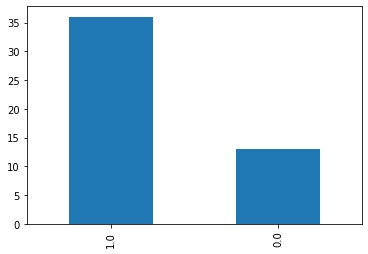

In [16]:
%matplotlib inline
fulldata.TARGET.value_counts().plot(kind='bar')

In [20]:
fulldata.TARGET.value_counts()

1.0    36
0.0    13
Name: TARGET, dtype: int64

In [17]:
fulldata.describe(include='all')

,Remote Direction_PSI_1,Image Name_PSI_1,Memory Usage_PSI_1,Remote Direction_PSI_2,Image Name_PSI_2,Memory Usage_PSI_2,Remote Direction_CHI_1,Image Name_CHI_1,Memory Usage_CHI_1,Remote Direction_CHI_2,Image Name_CHI_2,Memory Usage_CHI_2,TARGET
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,2.876508,0.741690,6.992426,4.410109,1.844828,7.403901,120.869552,5.548725,42.699102,122.928834,53.537206,44.239987,0.734694
std,1.020279,0.911330,0.490227,0.639315,0.877250,0.084871,221.138707,6.102535,4.664209,224.010718,36.551408,3.228387,0.446071
min,0.906616,0.037324,4.848816,3.399928,0.270617,7.246365,11.320209,0.013208,28.240854,29.011527,2.117009,40.653826,0.000000
25%,2.133585,0.103816,6.993787,4.115770,1.226436,7.353843,39.137025,1.274121,40.840369,46.593919,46.744277,42.106700,0.000000
50%,2.940777,0.298128,7.128746,4.251042,2.311091,7.398752,60.834128,2.971287,41.732591,60.221019,60.869212,42.863216,1.000000
75%,3.635303,1.735384,7.259508,4.599044,2.382501,7.449957,91.151282,11.537097,44.799575,80.980715,69.442381,45.057587,1.000000
max,4.741008,2.363721,7.370957,6.471241,2.454885,7.621727,996.169331,18.931581,51.396821,1013.722094,219.638430,52.457713,1.000000


In [18]:
fulldata.groupby(by='TARGET').describe(include='all')

Remote Direction_PSI_1                                          \
                        count      mean       std       min       25%   
TARGET                                                                  
0.0                      13.0  3.440261  0.887861  2.133585  2.543016   
1.0                      36.0  2.672931  0.998333  0.906616  1.988968   

                                     Image Name_PSI_1            ...  \
             50%       75%       max            count      mean  ...   
TARGET                                                           ...   
0.0     3.406620  3.936708  4.741008             13.0  0.866377  ...   
1.0     2.691243  3.423110  4.472663             36.0  0.696664  ...   

       Image Name_CHI_2             Memory Usage_CHI_2                       \
                    75%         max              count       mean       std   
TARGET                                                                        
0.0           57.124239   74.592769               13.0  44.422772  4.017678   
1.0           71.475869  219.638430               36.0  44.173981  2.956770   

                                                               
              min        25%        50%        75%        max  
TARGET                                                         
0.0     41.197160  41.921484  42.481406  46.174291  52.457713  
1.0     40.653826  42.241867  43.160006  44.866823  50.552847  

[2 rows x 96 columns]

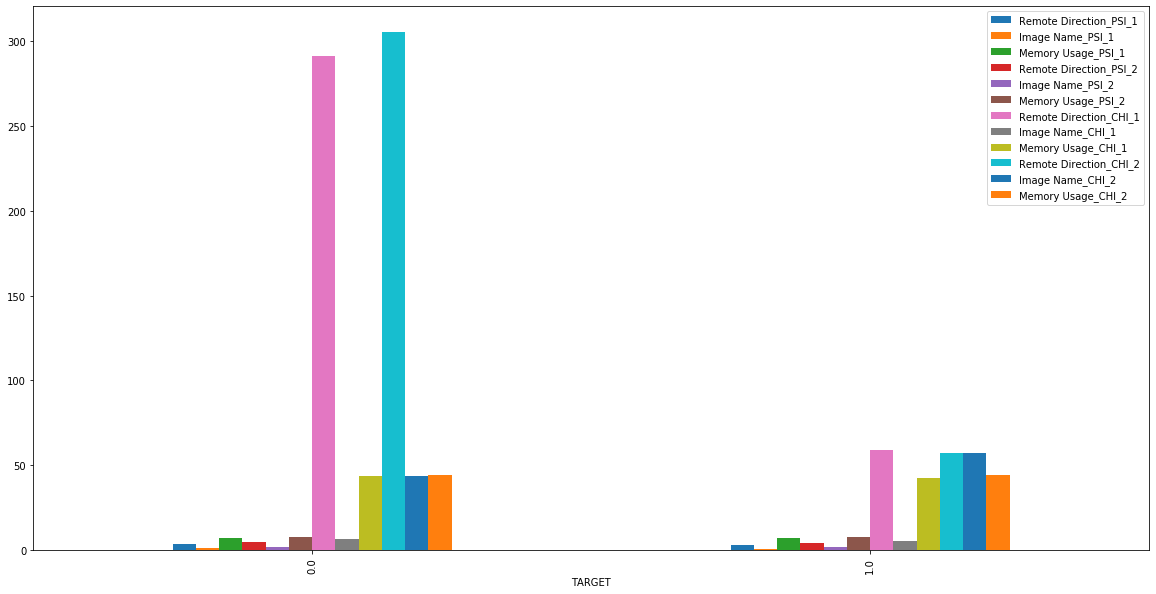

In [19]:
fulldata.groupby(by='TARGET').mean().plot(kind='bar',figsize=[20,10])

Group A: Camila Barbagallo, Ryan Daher, Paula Garcia and Rocio Gonzalez